# RAG for Data Science interview preparation

In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from tqdm import auto

C:\Users\mary\anaconda3-2024\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
model = SentenceTransformer('all-mpnet-base-v2')

In [3]:
ds = pd.read_csv('data/db.csv')
ds

,section,question,answer
0,Classic_models,What are various ways to predict a binary resp...,"Things to look at: N, P, linearly seperable?, ..."
1,Classic_models,What methods for solving linear regression do ...,"To solve linear regression, you need to find t..."
2,Classic_models,Maximum Likelihood Estimation for Linear Regre...,Linear regression can be written as a CPD in t...
3,Classic_models,MAP Estimation as Regularization,Maximum a-posteriori (MAP) method adds a prior...
4,Classic_models,Bayesian Linear Regression,Bayesian linear regression pushes the idea of ...
...,...,...,...
292,Statistics,How do you transform a Skewed Distribution int...,To transform a Skewed Distribution into a Norm...
293,Statistics,What's the difference between Binomial Distrib...,The Binomial distribution describes the probab...
294,Statistics,Bayesian Inference,Focusing solely on some statistic of the poste...
295,Statistics,Latent-Variable Models,"In practice, it is sometimes useful to have ad..."


In [4]:
ds['q+a'] = ds['question'] + ' ' + ds['answer']
ds

,section,question,answer,q+a
0,Classic_models,What are various ways to predict a binary resp...,"Things to look at: N, P, linearly seperable?, ...",What are various ways to predict a binary resp...
1,Classic_models,What methods for solving linear regression do ...,"To solve linear regression, you need to find t...",What methods for solving linear regression do ...
2,Classic_models,Maximum Likelihood Estimation for Linear Regre...,Linear regression can be written as a CPD in t...,Maximum Likelihood Estimation for Linear Regre...
3,Classic_models,MAP Estimation as Regularization,Maximum a-posteriori (MAP) method adds a prior...,MAP Estimation as Regularization Maximum a-pos...
4,Classic_models,Bayesian Linear Regression,Bayesian linear regression pushes the idea of ...,Bayesian Linear Regression Bayesian linear reg...
...,...,...,...,...
292,Statistics,How do you transform a Skewed Distribution int...,To transform a Skewed Distribution into a Norm...,How do you transform a Skewed Distribution int...
293,Statistics,What's the difference between Binomial Distrib...,The Binomial distribution describes the probab...,What's the difference between Binomial Distrib...
294,Statistics,Bayesian Inference,Focusing solely on some statistic of the poste...,Bayesian Inference Focusing solely on some sta...
295,Statistics,Latent-Variable Models,"In practice, it is sometimes useful to have ad...","Latent-Variable Models In practice, it is some..."


In [5]:
ds = ds.reset_index().rename(columns={'index': 'id'})

In [6]:
stats = ds.to_dict('records')

Let's encode the field, containing question and answer, into vector, so we can use it for the search:

In [7]:
for record in auto.tqdm(stats):
    record['q+a_vector'] = model.encode(record["q+a"])

  0%|          | 0/297 [00:00<?, ?it/s]

In [8]:
import pickle

with open('data/ds.pkl', 'wb') as f:
    pickle.dump(stats, f)

In [9]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 

es_client.info()

ObjectApiResponse({'name': 'd1afa5160e88', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'fkNVUkexQDeCEklNcE3vug', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [10]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "id": {"type": "keyword"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "answer": {"type": "text"},
            "q+a_vector": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"},
        }
    }
}

In [11]:
index_name = "data_science_db"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'data_science_db'})

In [12]:
for doc in auto.tqdm(stats):
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

  0%|          | 0/297 [00:00<?, ?it/s]

In [13]:
es_client.indices.refresh(index=index_name)
es_client.cat.count(index=index_name, format="json")

ListApiResponse([{'epoch': '1724517243', 'timestamp': '16:34:03', 'count': '297'}])

### Testing ElasticSearch:

In [14]:
search_term = "What is LDA?"
vector_search_term = model.encode(search_term)

In [15]:
query = {
    "field": "q+a_vector",
    "query_vector": vector_search_term,
    "k": 1,
    "num_candidates": 100, 
}

In [16]:
res = es_client.search(index=index_name, knn=query, source=["section", "question", "answer"])
res["hits"]["hits"]

[{'_index': 'data_science_db',
  '_id': '4EE8hZEBOVX6Ka3CcbnR',
  '_score': 0.79996276,
  '_ignored': ['q+a.keyword'],
  '_source': {'question': 'Linear Discriminant Analysis',
   'answer': 'Linear discriminant analysis is used as a tool for classification, dimension reduction, and data visualization. It has been around for quite some time now. Despite its simplicity, LDA often produces robust, decent, and interpretable classification results. When tackling real-world classification problems, LDA is often the benchmarking method before other more complicated and flexible ones are employed.\n',
   'section': 'Classic_models'}}]

In [20]:
# API_TOKEN = '...'

In [131]:
!pip install -U --user "huggingface_hub[cli]"

In [21]:
!huggingface-cli login --token=$API_TOKEN

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\mary\.cache\huggingface\token
Login successful


In [22]:
import requests
headers = {"Authorization": f"Bearer {API_TOKEN}"}
API_URL = "https://api-inference.huggingface.co/models/mistralai/Mixtral-8x7B-Instruct-v0.1"

In [23]:
from huggingface_hub import InferenceClient

In [24]:
headers = {"Authorization": f"Bearer {API_TOKEN}"}

client = InferenceClient("mistralai/Mixtral-8x7B-Instruct-v0.1", headers=headers)

In [25]:
def llm(prompt, max_tokens=500):
    return client.text_generation(prompt=prompt, max_new_tokens=max_tokens)

In [1]:
# from transformers import AutoTokenizer, MixtralForCausalLM

In [3]:
# model = MixtralForCausalLM.from_pretrained("mistralai/Mixtral-8x7B-Instruct-v0.1")

In [91]:
# def llm(prompt, max_tokens=500):
#     model = MixtralForCausalLM.from_pretrained("mistralai/Mixtral-8x7B-Instruct-v0.1")
#     tokenizer = AutoTokenizer.from_pretrained("mistralai/Mixtral-8x7B-Instruct-v0.1")
#     inputs = tokenizer(prompt, return_tensors="pt")
#     # Generate
#     generate_ids = model.generate(inputs.input_ids, max_length=max_tokens)
#     return tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

Templates for prompts for our tasks:

In [26]:
templates = {
    'quiz': """[INST]
You're interviewing a user for a Data Scientist position. Ask a question using the QUESTION and the CONTEXT that you get. 
The answer to the question that you ask should be in the CONTEXT.
You can rephrase the QUESTION or ask something different 
Make it short, do not give tips, do notgive the answer and do not write notes 
Don't start with 'Based on the context' or 'Question', just shoot it right away

QUESTION: {question}
CONTEXT: 
{context}
[/INST]
""",
    'question': """[INST]
You're an assistant, helping to prepare for a Data Scientist interview. Answer the QUESTION based on the CONTEXT from the DS database. 
Use only the facts from the CONTEXT when answering the QUESTION. If you don't have an answer in CONTEXT, say it and stop. Don't write any additional information. 
Don't start with 'Based on'

QUESTION: {question}

CONTEXT: 
{context}
[/INST]
"""
}

In [27]:
import random

In [28]:
def get_body(mode, query=None):
    # answering the question mode
    if mode == 'question':
        body = {
            'knn': {
                "field": "q+a_vector",
                "k": 5,
                "num_candidates": 100, 
                "query_vector": query
                },
            '_source': ["section", "question", "answer"]
        }
    # asking user a question mode
    if mode == 'quiz':
        body = {
    'size': 1,
    '_source': ["section", "question", "answer", "id"],
    'query': 
    {
        "function_score": 
        {
            "random_score": 
                {
                    "field": 'id',
                    "seed": random.randint(0, 10000000)
                },
           },
        }
    }
    return body

In [29]:
def elastic_search(query, mode):
    vector_search_term = model.encode(query)
    body = get_body(mode, vector_search_term)
    response = es_client.search(index=index_name, body=body)
    
    result_docs = []
    
    for hit in response['hits']['hits']:
        result_docs.append(hit['_source'])
    return result_docs

In [30]:
def build_prompt(query, search_results, mode):
    prompt_template = templates[mode].strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['answer']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [31]:
def rag(query, mode='question'):
    search_results = elastic_search(query, mode)
    prompt = build_prompt(query, search_results, mode)
    answer = llm(prompt)
    return answer.strip()

Getting answers to our questions:

In [33]:
print(rag('What is Transformer?'))

A transformer is a deep learning architecture based on the multi-head attention mechanism, proposed in the 2017 paper "Attention Is All You Need". It is composed of an encoder and a decoder, each made up of multiple layers of self-attention and feedforward neural networks. The self-attention mechanism allows the model to weigh the importance of different words in a sentence based on their affinity with each other, and positional bias helps the model keep track of the relative positions of words in a sentence. The transformer architecture is used for tasks like text classification, language translation, and language generation.


In [36]:
print(rag('What transformer can I use for text classification?'))

BERT is a transformer that can be used for text classification. It is a pre-trained transformer encoder model that can be fine-tuned for a wide range of NLP tasks, including sentiment analysis, topic classification, and spam detection.


In [37]:
print(rag('What is Adam?'))

Adam is an optimization algorithm used in machine learning, specifically for training neural networks. It is known as Adam, which stands for Adaptive Moment Estimation. It computes adaptive learning rates for each parameter, combining the advantages of both momentum and RMS-Prop methods. It is popular due to its ease of implementation, computational efficiency, and little memory requirements. It is used to minimize an error function or loss function, just like other optimizers.


Quizzing the user:

In [56]:
print(rag('', 'quiz'))

Why is it crucial to include non-linearity in a neural network through the use of activation functions, and what issues can arise if the output from a neuron is not restricted to a certain limit?


In [71]:
print(rag('', 'quiz'))

Could you explain how the Gradient Descent method can be used to solve linear regression problems?


## RAG evaluation

In [72]:
stats_sim = stats.copy()

In [74]:
ds['rag_answer'] = None

In [ ]:
for i, rec in auto.tqdm(ds.iterrows()):
    if rec['rag_answer'] is not None:
        continue
    answer_llm = rag(rec['question'])
    stats_sim[i]['rag_answer'] = answer_llm
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(rec['question'])
    similarity = v_llm.dot(v_orig)
    stats_sim[i]['similarity'] = similarity

In [ ]:
df_sim = pd.DataFrame(stats_sim)

In [ ]:
df_sim['similarity'].describe()

In [660]:
import seaborn as sns

C:\Users\mary\anaconda3-2024\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='similarity', ylabel='Density'>

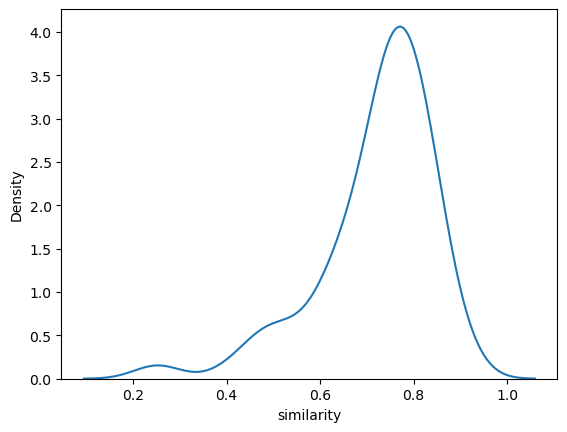

In [669]:
sns.kdeplot(df_sim['similarity'])

In [687]:
prompt_template = """[INST]
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer}
Generated Question: {question}
Generated Answer: {rag_answer}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
[/INST]""".strip()

In [688]:
record = stats_sim[0]

In [689]:
prompt = prompt_template.format(**record)

In [690]:
llm(prompt)

' {\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer compares and contrasts multiple methods for predicting a binary response variable, providing a detailed analysis of each method. This is highly relevant to the original answer, which also discusses various factors to consider when choosing between different prediction methods. The generated answer covers most of the key points from the original answer, such as the suitability of Logistic Regression for linear problems and the efficiency of SVM for non-linear problems, albeit in a more generalized manner."\n}'

In [692]:
import json

In [696]:
json_evaluations = []

for i, record in enumerate(auto.tqdm(stats_sim)):
    prompt = prompt_template.format(**record)
    result = llm(prompt)
    json_eval = json.loads(result)
    json_evaluations.append(json_eval)

  0%|          | 0/104 [00:00<?, ?it/s]

In [699]:
df_eval = pd.DataFrame(json_evaluations)

In [700]:
df_eval.Relevance.value_counts()

Relevance
RELEVANT           72
PARTLY_RELEVANT    29
NON_RELEVANT        3
Name: count, dtype: int64

In [703]:
df_sim = pd.concat([df_sim, df_eval], axis=1)

In [707]:
df_sim[df_sim['Relevance'] == 'NON_RELEVANT'][['question', 'answer', 'rag_answer']]

,question,answer,rag_answer
75,Matrix differentiation,"In mathematics, a real-valued function is call...","Based on the context provided, there is no dir..."
78,Why F1-Score is a Harmonic Mean(HM) of Precisi...,"Precision = 0, Recall = 1\r\nAvg = 0.5\r\nF1 =...",I don't have the answer to why F1-Score is a H...
88,What are the confidence intervals of the coeff...,Confidence interval (CI) is a type of interval...,Confidence intervals of the coefficients canno...


In [709]:
df_sim.to_csv('data/data_evaluation.csv')